# Prepare Problem

## Load libraries

Zona de importação das bibliotecas utilizadas neste trabalho.

In [302]:
import random
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
import scipy as sp
import scipy.stats as stats
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import model_selection
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor, VotingRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import BaggingRegressor
import pickle
import os
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Load dataset

É utilizado a biblioteca "Pandas" para se proceder à importação do ficheiro "pmsm_temperature_data.csv".
Neste ficheiro estão identificados vários dados de sensores adquiridos através de um "permanent magnet synchronous motor" (PMSM).  
É feita uma primeira visualização de uma pequena amostra das primeiras linhas do dataframe, para ter uma ideia do conteúdo dos dados.

In [303]:
electric_motor_temp = pd.read_csv('pmsm_temperature_data.csv')
electric_motor_temp.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


# Descriptive statistics, Data visualizations, Data Cleaning, Data transform

Nesta fase é feita a visualização das estatísticas descritivas e dos dados, e é realizado o tratamento e a limpeza dos mesmos.

In [3]:
electric_motor_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998070 entries, 0 to 998069
Data columns (total 13 columns):
ambient           998070 non-null float64
coolant           998070 non-null float64
u_d               998070 non-null float64
u_q               998070 non-null float64
motor_speed       998070 non-null float64
torque            998070 non-null float64
i_d               998070 non-null float64
i_q               998070 non-null float64
pm                998070 non-null float64
stator_yoke       998070 non-null float64
stator_tooth      998070 non-null float64
stator_winding    998070 non-null float64
profile_id        998070 non-null int64
dtypes: float64(12), int64(1)
memory usage: 99.0 MB


Podemos observar que o dataframe tem 998070 dados, tem 13 colunas, todos os dados são do tipo numpy float64, à excepção dos dados da coluna "profile_id", que é do tipo numpy int64.

In [4]:
electric_motor_temp.isnull().any()

ambient           False
coolant           False
u_d               False
u_q               False
motor_speed       False
torque            False
i_d               False
i_q               False
pm                False
stator_yoke       False
stator_tooth      False
stator_winding    False
profile_id        False
dtype: bool

O dataframe não tem quaisqueres missing values, i.e., None ou NaN ou Null. Por esse motivo não é necessário proceder ao tratamento de missing values.

In [5]:
electric_motor_temp.describe()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
count,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000
mean,-0.003905,0.004723,0.004780,-0.005690,-0.006336,-0.003333,0.006043,-0.003194,-0.004396,0.000609,-0.002208,-0.003935,50.732001
std,0.993127,1.002423,0.997878,1.002330,1.001229,0.997907,0.998994,0.997912,0.995686,1.001049,0.999597,0.998343,22.073125
min,-8.573954,-1.429349,-1.655373,-1.861463,-1.371529,-3.345953,-3.245874,-3.341639,-2.631991,-1.834688,-2.066143,-2.019973,4.000000
25%,-0.599385,-1.037925,-0.826359,-0.927390,-0.951892,-0.266917,-0.756296,-0.257269,-0.672308,-0.747265,-0.761951,-0.725622,32.000000
50%,0.266157,-0.177187,0.267542,-0.099818,-0.140246,-0.187246,0.213935,-0.190076,0.094367,-0.057226,0.005085,0.006536,56.000000
75%,0.686675,0.650709,0.358491,0.852625,0.853584,0.547171,1.013975,0.499260,0.680691,0.697344,0.772239,0.725660,68.000000
max,2.967117,2.649032,2.274734,1.793498,2.024164,3.016971,1.060937,2.914185,2.917456,2.449158,2.326668,2.653781,81.000000


Com esta informação, é permitido ter uma visão geral do dataframe.

Existe a necessidade de visualizar as horas das sessões de medição de forma a descobrir outliers, isto porque as temperaturas dentro dos motores elétricos precisam de tempo para variar.

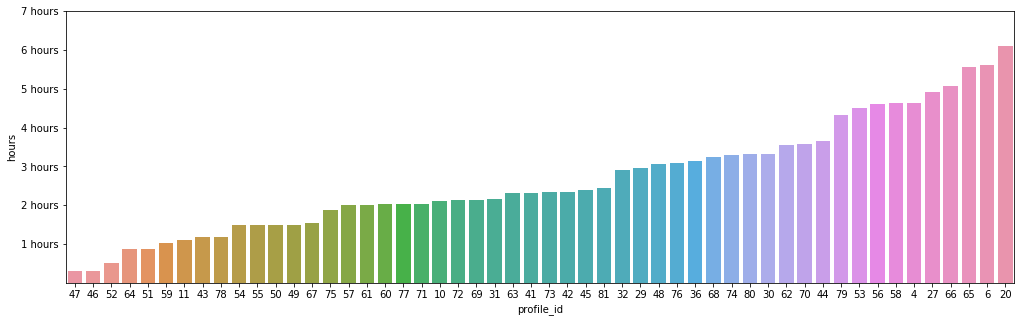

In [6]:
fig = plt.figure(figsize=(17, 5))
grpd = electric_motor_temp.groupby(['profile_id'])
df = grpd.size().sort_values().rename('hours').reset_index()
ordered_ids = df.profile_id.values.tolist()
sns.barplot(y='hours', x='profile_id', data=df, order=ordered_ids)
tcks = plt.yticks(2*3600*np.arange(1, 8), [f'{h} hours' for h in range(1, 8)])

Devido ao facto de termos quase 1 milhão de registos, decidi apenas incorporar os registos em que os "profile_id" contenham mais de 4 horas (28800 segundos = 4 horas), diminuindo assim o tempo de processamento e evitando erros de memória.

In [304]:
id_hours = electric_motor_temp.groupby(['profile_id']).size().sort_values().rename('hours').reset_index()
list_ids = id_hours[id_hours.hours>28800].profile_id.tolist()
final_df = pd.DataFrame(columns=['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'torque', 'i_d', 'i_q', 'pm', 'stator_yoke', 'stator_winding', 'stator_tooth', 'profile_id'])
for id_profile in list_ids:
    df_tmp = electric_motor_temp[electric_motor_temp.profile_id==id_profile]
    final_df = final_df.append(df_tmp)
electric_motor_temp = final_df
electric_motor_temp.describe()

,ambient,coolant,i_d,i_q,motor_speed,pm,stator_tooth,stator_winding,stator_yoke,torque,u_d,u_q
count,359805.000000,359805.000000,359805.000000,359805.000000,359805.000000,359805.000000,359805.000000,359805.000000,359805.000000,359805.000000,359805.000000,359805.000000
mean,0.426864,-0.094382,-0.114097,-0.006066,0.191208,0.218805,0.030551,0.044773,-0.019619,-0.000824,-0.091350,0.131059
std,0.775579,1.019257,1.012749,0.949974,1.018726,1.006465,1.043888,1.046911,1.033639,0.951007,1.047481,0.986080
min,-4.626428,-1.326642,-3.245874,-3.341639,-1.222586,-2.587304,-2.066143,-2.019973,-1.834688,-3.345953,-1.655373,-1.861463
25%,-0.006626,-1.064644,-0.987358,-0.257225,-0.762507,-0.434305,-0.762237,-0.726025,-0.799886,-0.265454,-1.081585,-0.714639
50%,0.605760,-0.300796,0.007062,-0.064500,0.130298,0.223352,0.014904,0.017978,-0.093348,-0.068900,0.126872,0.183687
75%,0.693746,0.609588,0.978846,0.520801,1.145090,0.981127,0.858681,0.841082,0.717334,0.550039,0.350972,0.900347
max,2.967117,2.287928,1.060175,2.892222,2.024164,2.917456,2.302169,2.550385,2.449158,2.861490,2.274734,1.793498


Iremos passar a ter 359805 registos.

A variável "profile_id" irá ser apagada por não ser útil para o nosso objetivo.

In [305]:
del electric_motor_temp['profile_id']

Iremos averiguar se existem outliers em cada uma das variáveis.
São apagados todos os outliers de forma automática, caso existam.

Função que devolve os limite inferior e superior do boxplot, de acordo com a variável que é passada.

In [306]:
def get_whiskers(field):
    q1 = electric_motor_temp[field].quantile(0.25)
    q3 = electric_motor_temp[field].quantile(0.75)
    iqr = q3 - q1
    lower_whisker = q1 - 1.5 * iqr
    upper_whisker = q3 + 1.5 * iqr
    return lower_whisker, upper_whisker

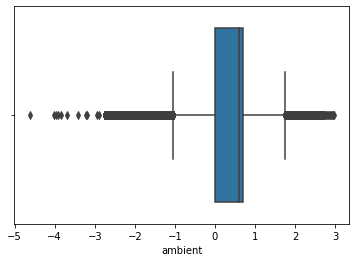

In [10]:
sns.boxplot(electric_motor_temp['ambient'])

In [307]:
lower_whisker, upper_whisker = get_whiskers('ambient')
electric_motor_temp.drop(electric_motor_temp[(electric_motor_temp['ambient'] < lower_whisker) | (electric_motor_temp['ambient'] > upper_whisker)].index,inplace=True)

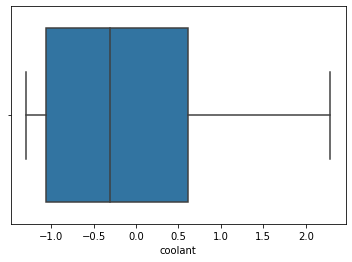

In [12]:
sns.boxplot(electric_motor_temp['coolant'])

In [308]:
lower_whisker, upper_whisker = get_whiskers('coolant')
electric_motor_temp.drop(electric_motor_temp[(electric_motor_temp['coolant'] < lower_whisker) | (electric_motor_temp['coolant'] > upper_whisker)].index,inplace=True)

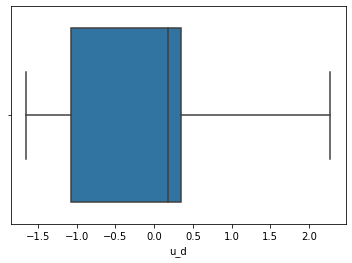

In [14]:
sns.boxplot(electric_motor_temp['u_d'])

In [309]:
lower_whisker, upper_whisker = get_whiskers('u_d')
electric_motor_temp.drop(electric_motor_temp[(electric_motor_temp['u_d'] < lower_whisker) | (electric_motor_temp['u_d'] > upper_whisker)].index,inplace=True)

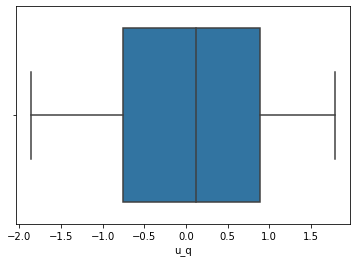

In [16]:
sns.boxplot(electric_motor_temp['u_q'])

In [310]:
lower_whisker, upper_whisker = get_whiskers('u_q')
electric_motor_temp.drop(electric_motor_temp[(electric_motor_temp['u_q'] < lower_whisker) | (electric_motor_temp['u_q'] > upper_whisker)].index,inplace=True)

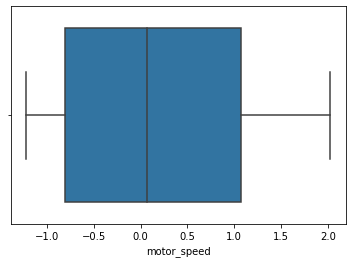

In [18]:
sns.boxplot(electric_motor_temp['motor_speed'])

In [311]:
lower_whisker, upper_whisker = get_whiskers('motor_speed')
electric_motor_temp.drop(electric_motor_temp[(electric_motor_temp['motor_speed'] < lower_whisker) | (electric_motor_temp['motor_speed'] > upper_whisker)].index,inplace=True)

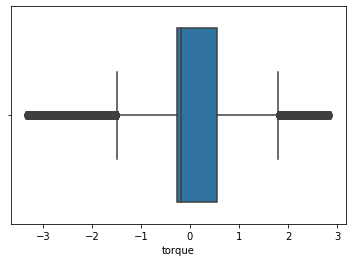

In [20]:
sns.boxplot(electric_motor_temp['torque'])

In [312]:
lower_whisker, upper_whisker = get_whiskers('torque')
electric_motor_temp.drop(electric_motor_temp[(electric_motor_temp['torque'] < lower_whisker) | (electric_motor_temp['torque'] > upper_whisker)].index,inplace=True)

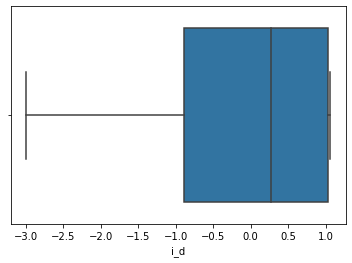

In [22]:
sns.boxplot(electric_motor_temp['i_d'])

In [313]:
lower_whisker, upper_whisker = get_whiskers('i_d')
electric_motor_temp.drop(electric_motor_temp[(electric_motor_temp['i_d'] < lower_whisker) | (electric_motor_temp['i_d'] > upper_whisker)].index,inplace=True)

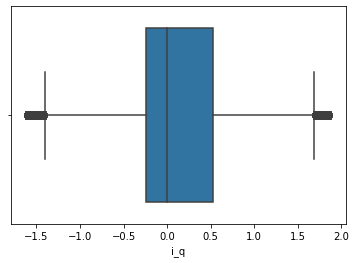

In [24]:
sns.boxplot(electric_motor_temp['i_q'])

In [314]:
lower_whisker, upper_whisker = get_whiskers('i_q')
electric_motor_temp.drop(electric_motor_temp[(electric_motor_temp['i_q'] < lower_whisker) | (electric_motor_temp['i_q'] > upper_whisker)].index,inplace=True)

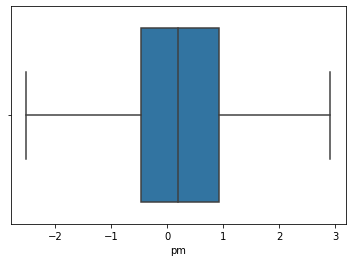

In [26]:
sns.boxplot(electric_motor_temp['pm'])

In [315]:
lower_whisker, upper_whisker = get_whiskers('pm')
electric_motor_temp.drop(electric_motor_temp[(electric_motor_temp['pm'] < lower_whisker) | (electric_motor_temp['pm'] > upper_whisker)].index,inplace=True)

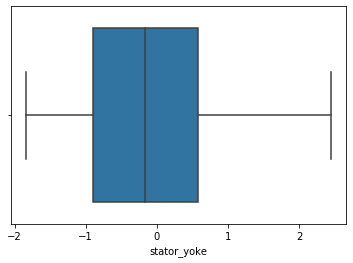

In [28]:
sns.boxplot(electric_motor_temp['stator_yoke'])

In [316]:
lower_whisker, upper_whisker = get_whiskers('stator_yoke')
electric_motor_temp.drop(electric_motor_temp[(electric_motor_temp['stator_yoke'] < lower_whisker) | (electric_motor_temp['stator_yoke'] > upper_whisker)].index,inplace=True)

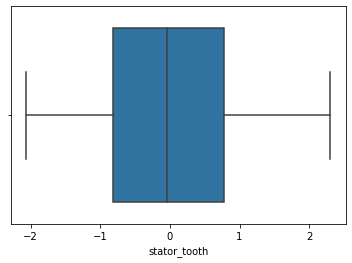

In [30]:
sns.boxplot(electric_motor_temp['stator_tooth'])

In [317]:
lower_whisker, upper_whisker = get_whiskers('stator_tooth')
electric_motor_temp.drop(electric_motor_temp[(electric_motor_temp['stator_tooth'] < lower_whisker) | (electric_motor_temp['stator_tooth'] > upper_whisker)].index,inplace=True)

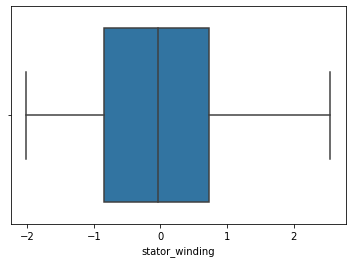

In [32]:
sns.boxplot(electric_motor_temp['stator_winding'])

In [318]:
lower_whisker, upper_whisker = get_whiskers('stator_winding')
electric_motor_temp.drop(electric_motor_temp[(electric_motor_temp['stator_winding'] < lower_whisker) | (electric_motor_temp['stator_winding'] > upper_whisker)].index,inplace=True)

In [319]:
electric_motor_temp.describe()

,ambient,coolant,i_d,i_q,motor_speed,pm,stator_tooth,stator_winding,stator_yoke,torque,u_d,u_q
count,289758.000000,289758.000000,289758.000000,289758.000000,289758.000000,289758.000000,289758.000000,289758.000000,289758.000000,289758.000000,289758.000000,289758.000000
mean,0.367319,-0.111953,-0.019515,0.116685,0.213261,0.196817,-0.053530,-0.061682,-0.081179,0.121303,-0.236723,0.169004
std,0.627556,1.027943,1.035106,0.645683,1.057923,1.000775,1.042783,1.044572,1.029018,0.647347,0.911297,1.027532
min,-1.057169,-1.296269,-2.996538,-1.406333,-1.222586,-2.524219,-2.066143,-2.019973,-1.834688,-1.496452,-1.654878,-1.555451
25%,-0.051109,-1.066119,-0.926455,-0.245729,-0.924734,-0.473801,-0.818105,-0.845307,-0.892282,-0.256025,-1.121417,-0.785496
50%,0.528022,-0.502473,0.274385,0.002237,0.203675,0.187984,-0.043042,-0.040602,-0.168824,-0.003786,0.036122,0.390364
75%,0.688609,0.609588,1.029132,0.529435,1.212483,0.920902,0.781723,0.729347,0.578475,0.552963,0.330397,0.953562
max,1.743692,2.287928,1.060175,1.688551,2.024164,2.917252,2.302169,2.550385,2.440772,1.786242,2.217656,1.793498


Após a remoção dos outliers, ficamos com 289758 registos

São criadas 2 novas variáveis e eliminadas as variáveis que ajudaram a criar essas novas variáveis.

In [320]:
electric_motor_temp['voltage'] = np.sqrt(electric_motor_temp['u_d']**2 + electric_motor_temp['u_q']**2)
electric_motor_temp['current'] = np.sqrt(electric_motor_temp['i_d']**2 + electric_motor_temp['i_q']**2)
electric_motor_temp['apparent_power'] = electric_motor_temp['voltage'] * electric_motor_temp['current']
electric_motor_temp['effective_power'] = electric_motor_temp['i_d'] * electric_motor_temp['u_d'] + electric_motor_temp['i_q'] * electric_motor_temp['u_q']

del electric_motor_temp['u_d']
del electric_motor_temp['u_q']
del electric_motor_temp['i_q']
del electric_motor_temp['i_d']

electric_motor_temp.head()

,ambient,coolant,motor_speed,pm,stator_tooth,stator_winding,stator_yoke,torque,voltage,current,apparent_power,effective_power
910123,-0.395889,-0.745004,-1.222131,-2.358825,-1.812809,-1.778477,-1.538836,-0.255481,1.292161,1.058005,1.367112,0.626732
910124,-0.400168,-0.744249,-1.207187,-2.358744,-1.813096,-1.778032,-1.537904,-0.021036,1.248968,0.921746,1.151231,0.245073
910125,-0.396108,-0.742709,-1.158549,-2.357891,-1.813211,-1.777942,-1.537237,0.565930,1.151661,0.780464,0.898830,-0.602844
910126,-0.391694,-0.741395,-1.100764,-2.355653,-1.810990,-1.776171,-1.536759,1.085251,1.063548,1.128481,1.200194,-1.191602
910127,-0.381406,-0.740259,-1.058045,-2.353463,-1.809399,-1.774743,-1.540100,1.465298,1.007853,1.523665,1.535630,-1.509038


Vamos agora averiguar se existem duplicados.

In [36]:
print("Existem {} duplicados".format(electric_motor_temp.duplicated().sum()))

Existem 0 duplicados


# Feature Selection

São aplicados vários métodos de feature selection para identificar as variáveis com maior importância para o nosso target "pm".

In [321]:
features = electric_motor_temp.drop('pm', 1)
target = electric_motor_temp['pm']

## F-Test

In [38]:
best_features=SelectKBest(score_func=f_regression,k=5).fit_transform(features,target)

print(best_features[:5])
print("")
print(features.head())

[[-0.74500394 -1.2221307  -1.8128086  -1.7784774  -1.5388355 ]
 [-0.7442489  -1.2071872  -1.8130957  -1.778032   -1.5379043 ]
 [-0.742709   -1.1585491  -1.8132111  -1.7779425  -1.5372369 ]
 [-0.7413948  -1.1007643  -1.8109901  -1.776171   -1.5367589 ]
 [-0.7402589  -1.0580451  -1.8093987  -1.7747426  -1.5401002 ]]

         ambient   coolant  motor_speed  stator_tooth  stator_winding  \
910123 -0.395889 -0.745004    -1.222131     -1.812809       -1.778477   
910124 -0.400168 -0.744249    -1.207187     -1.813096       -1.778032   
910125 -0.396108 -0.742709    -1.158549     -1.813211       -1.777942   
910126 -0.391694 -0.741395    -1.100764     -1.810990       -1.776171   
910127 -0.381406 -0.740259    -1.058045     -1.809399       -1.774743   

        stator_yoke    torque   voltage   current  apparent_power  \
910123    -1.538836 -0.255481  1.292161  1.058005        1.367112   
910124    -1.537904 -0.021036  1.248968  0.921746        1.151231   
910125    -1.537237  0.565930  1.1516

Com a informação acima, conseguimos concluir através deste método que as variáveis "coolant", "motor_speed", "stator_yoke", "stator_tooth" e "stator_winding" são as 5 variáveis com maior importância.

## Heatmap

Irá ser criado um heatmap para nos dar uma visualização de quais as variáveis com maior correlação entre elas e analisar as variáveis que são de maior interesse para o nosso estudo. Neste caso queremos saber quais as variáveis com maior correlação com a variável "pm".

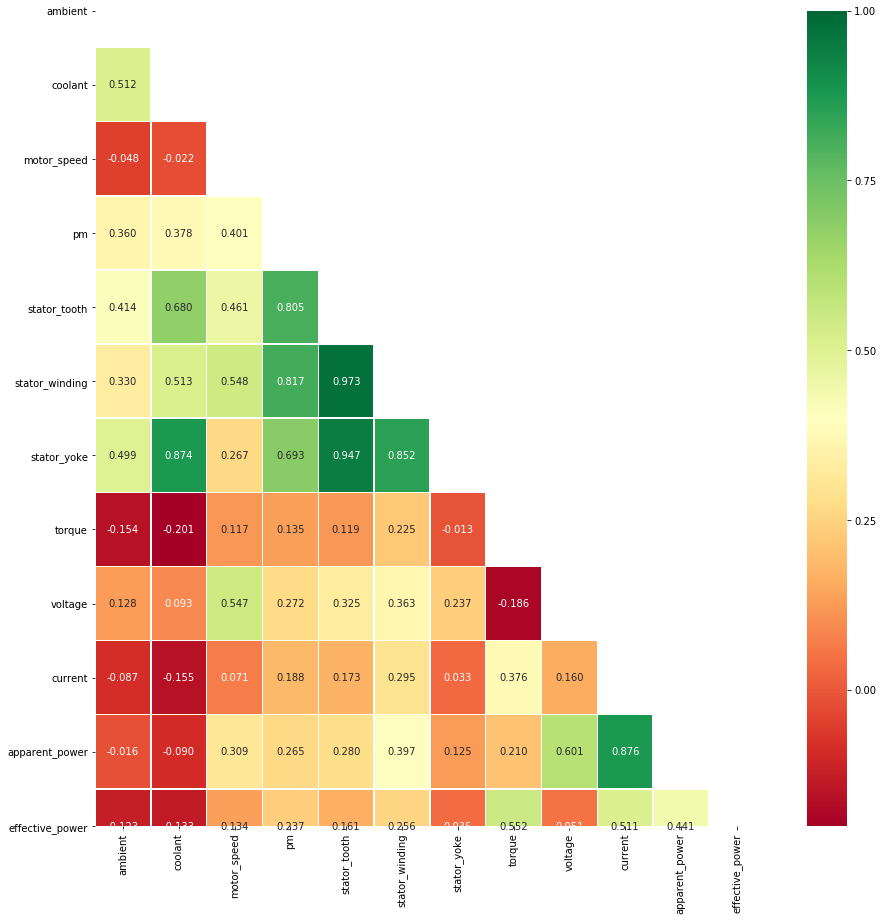

In [39]:
f, ax = plt.subplots(figsize = (15,15))
mask = np.zeros_like(electric_motor_temp.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(electric_motor_temp.corr(), mask=mask, annot=True, fmt=".3f", linewidths=0.5, ax=ax, cmap='RdYlGn')

É possivel verificar que as variáveis que têm maior correlação com a variável "pm" são as variáveis "stator_yoke", "stator_winding" e "stator_tooth".

## Pairplot

De seguida iremos criar um Pairplot com variáveis que têm maior correlação com a variável "pm", i.e., "stator_yoke", "stator_winding" e "stator_tooth".

In [322]:
features = ['stator_yoke', 'stator_winding', 'stator_tooth', 'pm']
sns.pairplot(electric_motor_temp, vars=features, aspect=0.5)

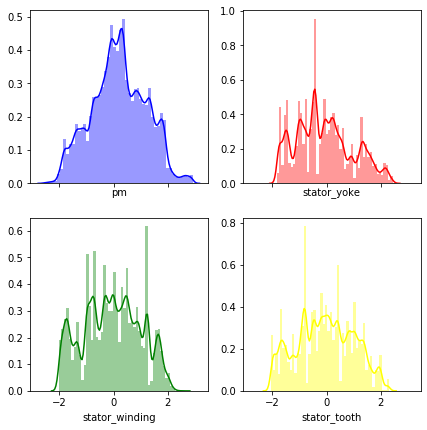

In [41]:
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
sns.distplot(electric_motor_temp["pm"], color="blue", ax=axes[0, 0])
sns.distplot(electric_motor_temp["stator_yoke"], color="red", ax=axes[0, 1])
sns.distplot(electric_motor_temp["stator_winding"], color="green", ax=axes[1, 0])
sns.distplot(electric_motor_temp["stator_tooth"], color="yellow", ax=axes[1, 1])

Iremos passar à análise das variavéis com maior correlação.

## Regressão Linear

É realizada regressão linear entre as variáveis descritas.
É calculado o coeficiente de determinação, correlação de pearson e spearman entre as mesmas.

In [42]:
def linear_regression(field_1, field_2):
    var_1 = electric_motor_temp[field_1]
    var_2 = electric_motor_temp[field_2]
    
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(var_1, var_2)
    electric_motor_temp.plot(x=field_1, y=field_2, kind='scatter')
    plt.plot(var_1,var_1*slope+intercept,'r')
    plt.show()
    print ("r-squared : {}".format(r_value**2))
    print ("Pearson correlation : {}".format(pearsonr(var_1, var_2)[0]))
    print ("Spearman correlation : {}".format(spearmanr(var_1, var_2)[0]))

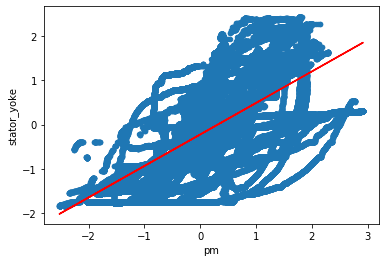

r-squared : 0.479656251371534
Pearson correlation : 0.6925721993926237
Spearman correlation : 0.7047789329472343


In [43]:
linear_regression('pm', 'stator_yoke')

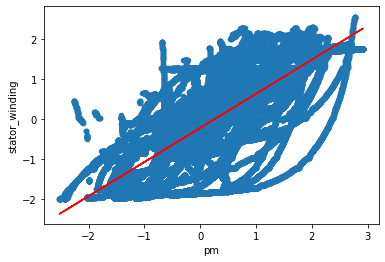

r-squared : 0.6670267883223199
Pearson correlation : 0.8167170797297684
Spearman correlation : 0.8164029164227785


In [44]:
linear_regression('pm', 'stator_winding')

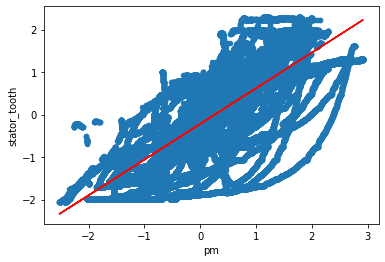

r-squared : 0.6478230471776076
Pearson correlation : 0.8048745536899572
Spearman correlation : 0.80813798964034


In [45]:
linear_regression('pm', 'stator_tooth')

Apesar da quantidade de dados ser muito grande e dispares, conseguimos concluir que:

- O valor do campo "pm" aumenta significativamente com o aumento das variáveis "stator_yoke", "stator_winding" e "stator_tooth".

## Kolmogorov-Smirnov test, CDF e ECDF

In [46]:
def distribution(field):
    var = electric_motor_temp[field]
    sns.kdeplot(var, shade=True)
    return

In [47]:
def sk_plot_norm(field):
    var = electric_motor_temp[field]
    length = len(var)
    mu = sp.mean(var)
    plt.figure(figsize=(12, 7))
    plt.plot(np.sort(var), np.linspace(0, 1, length), linewidth=3.0)
    plt.plot(np.sort(stats.norm.rvs(loc=mu, scale=0.5, size=length)), np.linspace(0, 1, length), linewidth=3.0, color="r")
    plt.legend('top right')
    plt.legend(['CDF', 'ECDF'])
    plt.title(field)
    plt.show()

In [48]:
def cdf(field):
    var = electric_motor_temp[field]
    var.hist(cumulative = True)
    sorted_field = np.sort(var)
    plt.step(sorted_field, np.arange(sorted_field.size), linewidth=5.0, color="r")
    plt.show()

In [49]:
def sk_test_2samp(field):
    var = electric_motor_temp[field]
    length = len(var)
    half_length = int(length/2)
    first_half = var.iloc[half_length:]
    second_half = var.iloc[:half_length]
    p_value = 0.05
    sk_2samp = stats.ks_2samp(first_half, second_half)
    print (str(field.upper()) + "\n\n" + str(sk_2samp))
    if sk_2samp[1] < p_value:
        print("É rejeitada a hipótese nula")
    else:
        print("Não é rejeitada a hipótese nula")
        
    return first_half, second_half

In [50]:
def ks_plot_comp_cdf(field, first_half, second_half):
    mu_1 = sp.mean(first_half)
    mu_2 = sp.mean(second_half)
    plt.figure(figsize=(12, 7))
    
    if mu_1 > mu_2:
        diff_mu = mu_1 - mu_2
        plt.plot(np.sort(first_half), np.linspace(0, 1, len(first_half), endpoint=False), linewidth=3.0)
        plt.plot(np.sort(second_half + diff_mu), np.linspace(0, 1, len(second_half), endpoint=False), linewidth=3.0, color="r")
    if mu_1 < mu_2:
        diff_mu = mu_2 - mu_1
        plt.plot(np.sort(first_half + diff_mu), np.linspace(0, 1, len(first_half), endpoint=False), linewidth=3.0)
        plt.plot(np.sort(second_half), np.linspace(0, 1, len(second_half), endpoint=False), linewidth=3.0, color="r")
        
    plt.legend('top right')
    plt.legend(['First half', 'Second half'])
    plt.title('Comparing ' + str(field) + ' first half and fecond half CDFs')
    plt.xticks([])
    plt.show()

In [51]:
def ks_plot_comp_ecdf(field, first_half, second_half):
    mu_1 = sp.mean(first_half)
    mu_2 = sp.mean(second_half)
    plt.figure(figsize=(12, 7))
    
    if mu_1 > mu_2:
        diff_mu = mu_1 - mu_2
        plt.plot(np.sort(stats.norm.rvs(loc=first_half, scale=5, size=len(first_half))), np.linspace(0, 1, len(first_half), endpoint=False), linewidth=3.0, color="g")
        plt.plot(np.sort(stats.norm.rvs(loc=sp.mean(second_half + diff_mu), scale=5, size=len(second_half))), np.linspace(0, 1, len(second_half), endpoint=False), linewidth=3.0, color="orange")
    if mu_1 < mu_2:
        diff_mu = mu_2 - mu_1
        plt.plot(np.sort(stats.norm.rvs(loc=sp.mean(first_half + diff_mu), scale=5, size=len(first_half))), np.linspace(0, 1, len(first_half), endpoint=False), linewidth=3.0, color="g")
        plt.plot(np.sort(stats.norm.rvs(loc=second_half, scale=5, size=len(second_half))), np.linspace(0, 1, len(second_half), endpoint=False), linewidth=3.0, color="orange")
        
    plt.legend('top right')
    plt.legend(['First half', 'Second half'])
    plt.title('Comparing ' + str(field) + ' first half and fecond half ECDFs')
    plt.xticks([])
    plt.show()

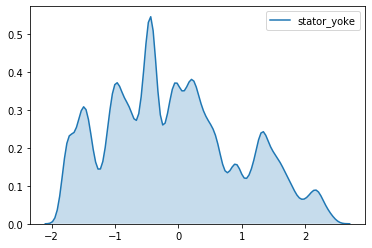

In [52]:
distribution('stator_yoke')

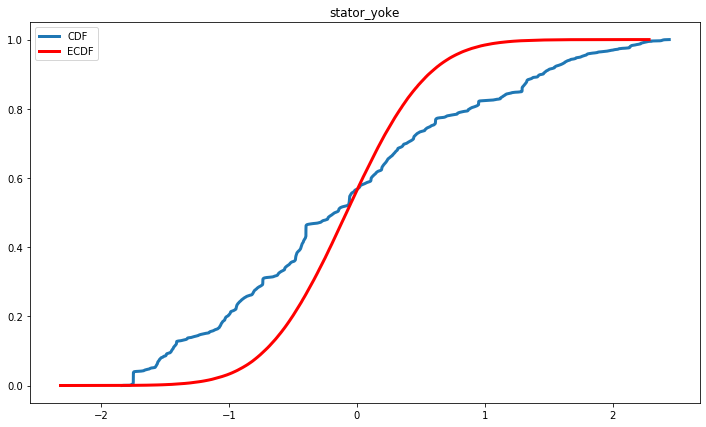

In [53]:
sk_plot_norm('stator_yoke')

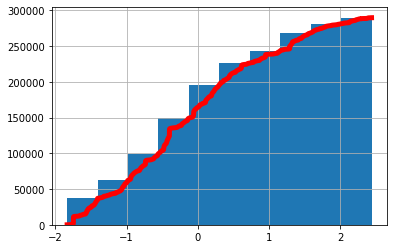

In [54]:
cdf('stator_yoke')

In [55]:
first_half, second_half = sk_test_2samp('stator_yoke')

STATOR_YOKE

Ks_2sampResult(statistic=0.10993311660074967, pvalue=0.0)
É rejeitada a hipótese nula


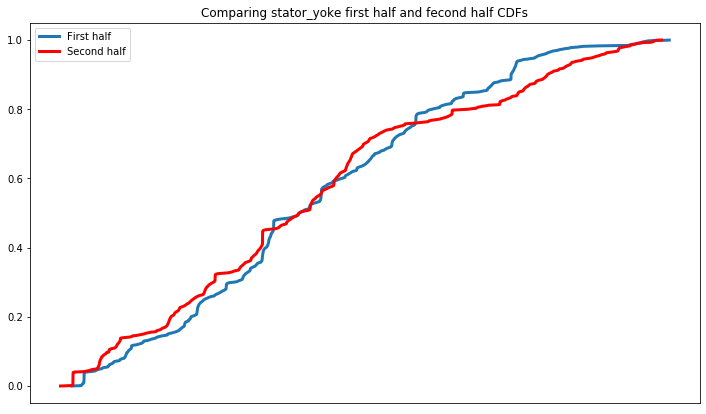

In [56]:
ks_plot_comp_cdf('stator_yoke', first_half, second_half)

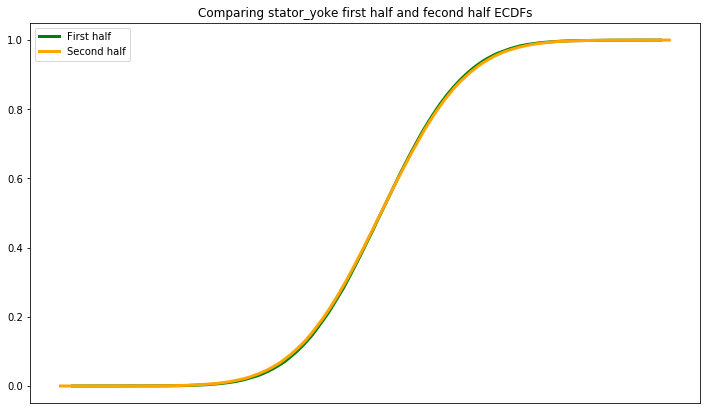

In [57]:
ks_plot_comp_ecdf('stator_yoke', first_half, second_half)

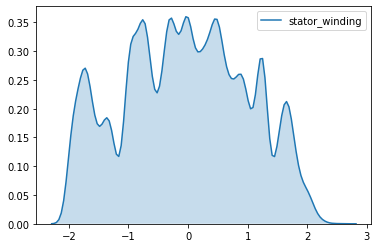

In [58]:
distribution('stator_winding')

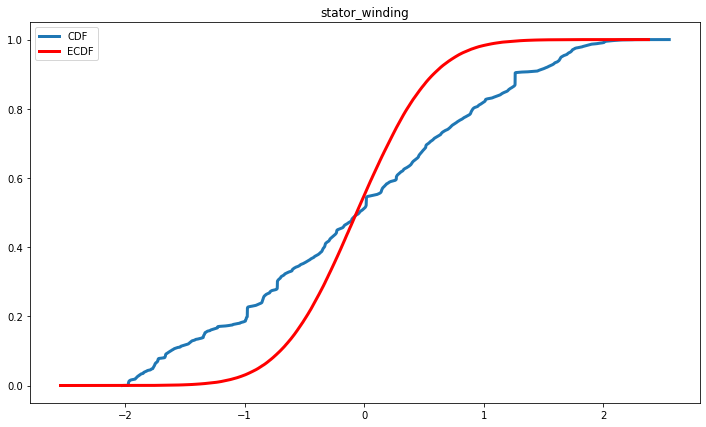

In [59]:
sk_plot_norm('stator_winding')

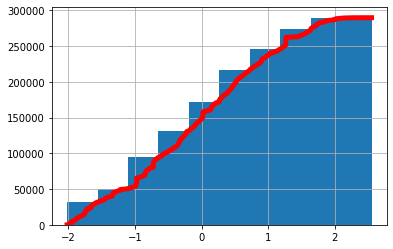

In [60]:
cdf('stator_winding')

In [61]:
first_half, second_half = sk_test_2samp('stator_winding')

STATOR_WINDING

Ks_2sampResult(statistic=0.09846147474789307, pvalue=0.0)
É rejeitada a hipótese nula


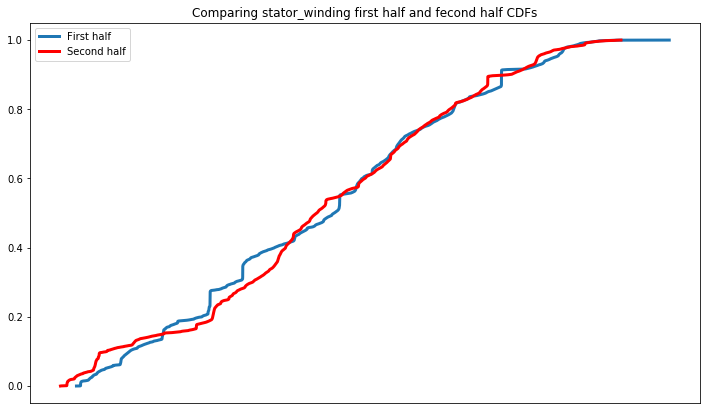

In [62]:
ks_plot_comp_cdf('stator_winding', first_half, second_half)

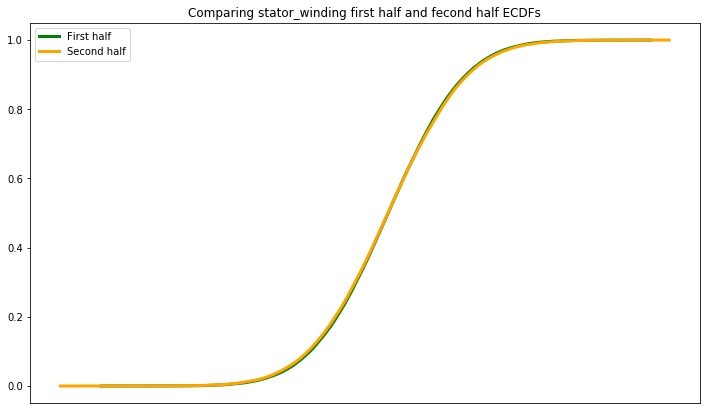

In [63]:
ks_plot_comp_ecdf('stator_winding', first_half, second_half)

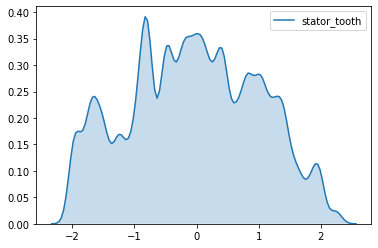

In [64]:
distribution('stator_tooth')

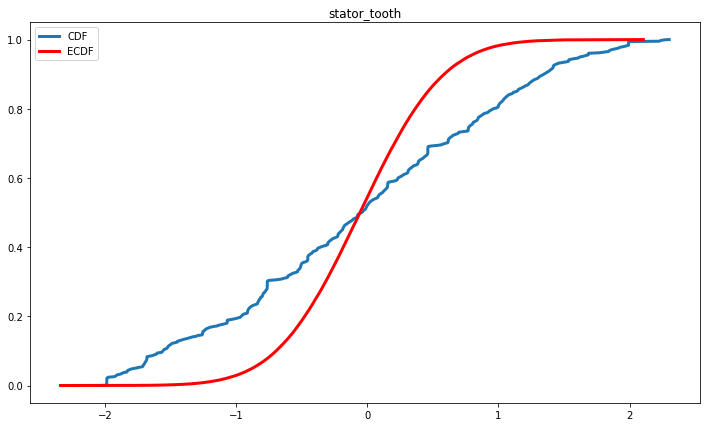

In [65]:
sk_plot_norm('stator_tooth')

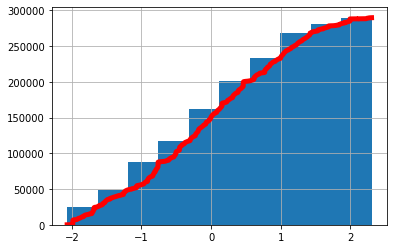

In [66]:
cdf('stator_tooth')

In [67]:
first_half, second_half = sk_test_2samp('stator_tooth')

STATOR_TOOTH

Ks_2sampResult(statistic=0.07692626260534652, pvalue=0.0)
É rejeitada a hipótese nula


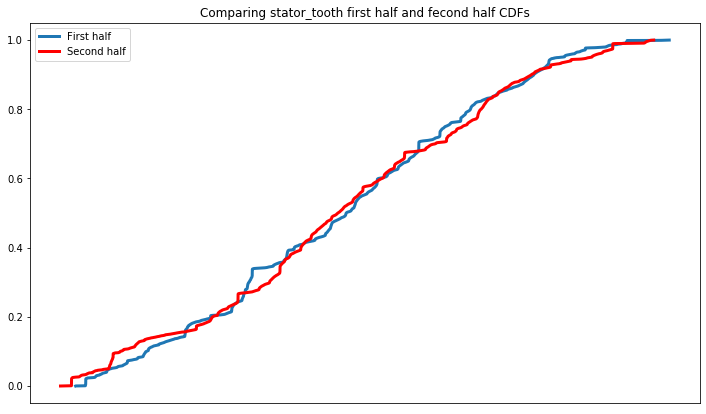

In [68]:
ks_plot_comp_cdf('stator_tooth', first_half, second_half)

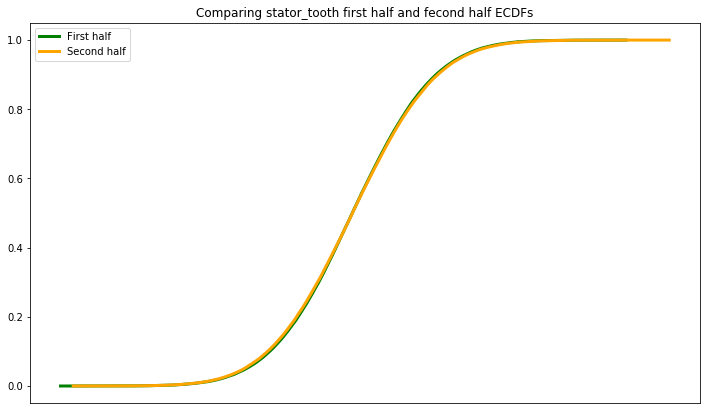

In [69]:
ks_plot_comp_ecdf('stator_tooth', first_half, second_half)

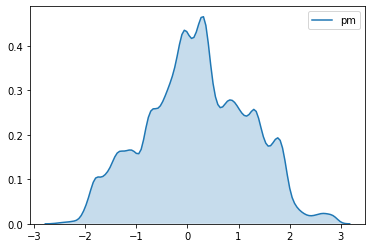

In [70]:
distribution('pm')

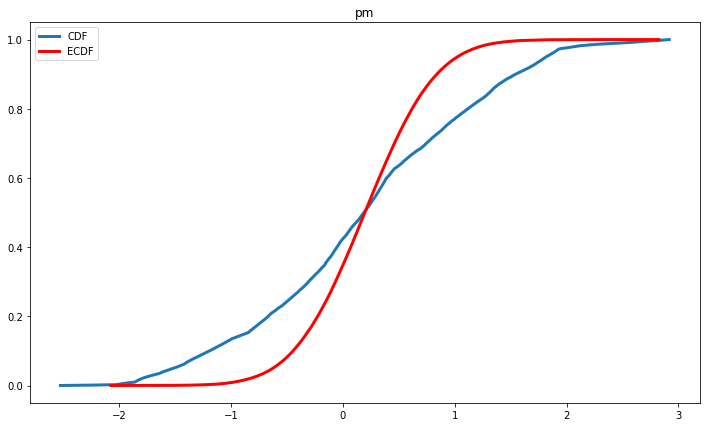

In [71]:
sk_plot_norm('pm')

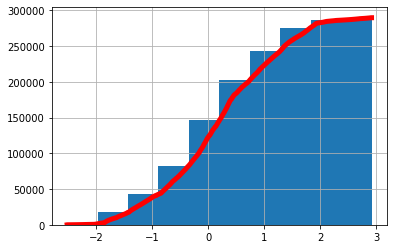

In [72]:
cdf('pm')

In [73]:
first_half, second_half = sk_test_2samp('pm')

PM

Ks_2sampResult(statistic=0.05590182152002706, pvalue=4.728263496815291e-197)
É rejeitada a hipótese nula


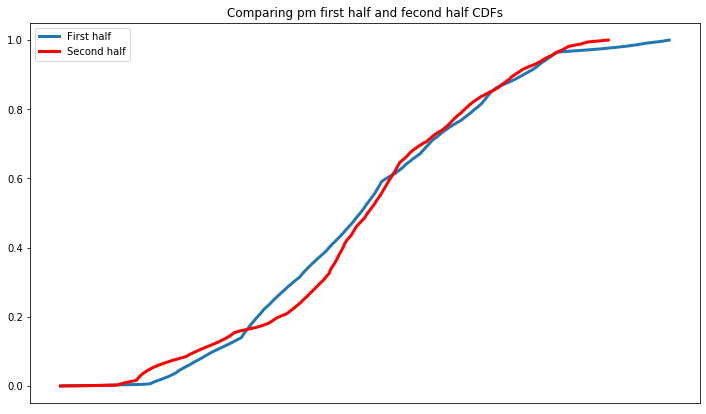

In [74]:
ks_plot_comp_cdf('pm', first_half, second_half)

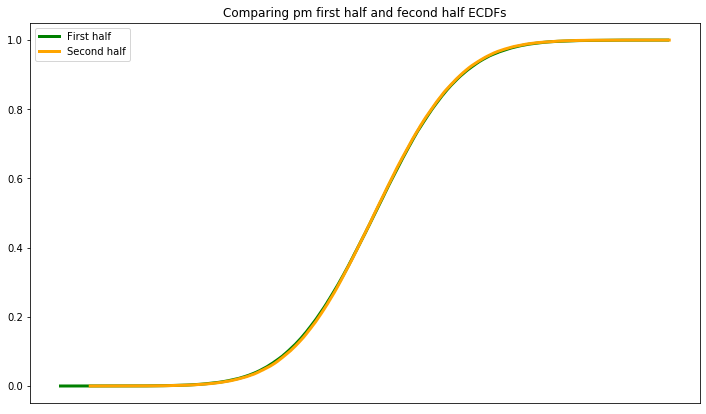

In [75]:
ks_plot_comp_ecdf('pm', first_half, second_half)

Visto que o valor p assume sempre o valor 0, i.e., valores tão baixos que arrendodados dão 0, é então rejeitada a hipotése nula. 
As distribuições de dados não seguem qualquer distribuição conhecida.

# Evaluate Algorithms

## Split-out validation dataset

Nesta fase é feita a separação das features e do target. Também é feita a divisão dos de treino (80%) e de teste (20%).

Primeiro separa-se as features do target e normaliza-se os dados das features.

In [323]:
electric_motor_temp = electric_motor_temp.loc[:,['stator_yoke', 'stator_winding', 'stator_tooth', 'pm']]
features = electric_motor_temp.drop('pm', 1)
target = electric_motor_temp['pm']

features = (features - np.min(features))/(np.max(features)-np.min(features))

De seguida divide-se os dados em dados de treino e de teste como já referido.

In [324]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

## Spot Check Algorithms

Nesta fase inicial iremos utilizar os seguintes modelos:

- Linear Regression
- Lasso Regression
- Ridge Regression
- Elastic Net Regression
- Decision Tree Regressor
- K-Nearest Neighbors Regressor
- Neural Network Regressor

Iremos agora definir esses modelos numa lista.

In [78]:
models = []
models.append(('Linear Regression', LinearRegression(fit_intercept=False, n_jobs = -1)))
models.append(('Lasso', Lasso(alpha=0.1)))
models.append(('Ridge', Ridge(alpha=0.1)))
models.append(('Elastic Net', ElasticNet(alpha=0.1)))
models.append(('Decision Tree', DecisionTreeRegressor(random_state = 42)))
models.append(('KNN', KNeighborsRegressor(n_neighbors=2, n_jobs = -1)))
models.append(('Neural Network', MLPRegressor(hidden_layer_sizes=(8,), activation='relu', solver='adam', verbose=0)))

## Test options and evaluation metric

Função com as métricas para os modelos definidos.
É aplicado o cross-validation.
As métricas utilizadas são:

- Mean Absolute Error
- Mean Squared Error
- R-Squared

Para comparação dos algoritmos iremos utilizar o R-Squared.

In [79]:
def metrics(models):
    results = []
    names = []
    for name, model in models:
        model.fit(x_train, y_train)
        predict_train = model.predict(x_train)
        predict_test = model.predict(x_test)
        results.append(r2_score(y_test, predict_test))
        names.append(name)
        
        print(name + ':')
        print('\tTrain:')
        print('\t\tMean Absolute Error: {}'.format(mean_absolute_error(y_train, predict_train)))
        print('\t\tMean Squared Error: {}'.format(mean_squared_error(y_train, predict_train)))
        print('\t\tR-Squared: {}'.format(r2_score(y_train, predict_train)))
        print('\tTest:')
        print('\t\tMean Absolute Error: {}'.format(mean_absolute_error(y_test, predict_test)))
        print('\t\tMean Squared Error: {}'.format(mean_squared_error(y_test, predict_test)))
        print('\t\tR-Squared: {}\n'.format(r2_score(y_test, predict_test)))
        
    return names, results

In [80]:
models_names, models_results = metrics(models)

Linear Regression:
	Train:
		Mean Absolute Error: 0.68742279595096
		Mean Squared Error: 0.7141514595116661
		R-Squared: 0.2867868398164052
	Test:
		Mean Absolute Error: 0.6903469739032742
		Mean Squared Error: 0.7170257347648824
		R-Squared: 0.2847435561618604

Lasso:
	Train:
		Mean Absolute Error: 0.5778026167754715
		Mean Squared Error: 0.5235013592912917
		R-Squared: 0.4771864513504498
	Test:
		Mean Absolute Error: 0.5787842330339418
		Mean Squared Error: 0.5247841529220344
		R-Squared: 0.4765107738780028

Ridge:
	Train:
		Mean Absolute Error: 0.40079966038807413
		Mean Squared Error: 0.28601394661436286
		R-Squared: 0.7143618373882502
	Test:
		Mean Absolute Error: 0.4011404534703283
		Mean Squared Error: 0.2861033281002587
		R-Squared: 0.7146026438028066

Elastic Net:
	Train:
		Mean Absolute Error: 0.5563468981019443
		Mean Squared Error: 0.4888126476448317
		R-Squared: 0.5118295866777747
	Test:
		Mean Absolute Error: 0.5573268397371031
		Mean Squared Error: 0.4901539215295923
		R

### Cross-validation

Vamos utilizar o cross-validation para avaliar a capacidade de generalização dos modelos.
A estratégia aplicada para validar o modelo foi o cross-validation Shuffle Split, que é um iterador recomendado para conjuntos de dados com um grande desequilíbrio na sua distribuição.
Dividi o conjunto em 10 grupos (splits), por 10 vezes, dos quais 8 foram usados para treino e 2 foram usados para teste.
O cross-validation é computacionalmente mais pesado, mas vale a pena o esforço.

In [325]:
shufflesplit = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

Função com as métricas utilizando cross-validation.

In [82]:
def metrics_cv(models, with_pca):
    results = []
    names = []
    for name, model in models:
        if not with_pca:
            model = make_pipeline(preprocessing.StandardScaler(), model)
        cv_mae = cross_val_score(model, features, target, cv=shufflesplit, scoring='neg_mean_absolute_error')
        cv_mse = cross_val_score(model, features, target, cv=shufflesplit, scoring='neg_mean_squared_error')
        cv_r2 = cross_val_score(model, features, target, cv=shufflesplit, scoring='r2')
        results.append(cv_r2.mean())
        names.append(name)
        
        print(name + ':')
        print('\tMean Absolute Error: {} ({})'.format(cv_mae.mean(), cv_mae.std()))
        print('\tMean Squared Error: {} ({})'.format(cv_mse.mean(), cv_mse.std()))
        print('\tR-Squared: {} ({})\n'.format(cv_r2.mean(), cv_r2.std()))
    
    return names, results

In [83]:
models_names_cv, models_results_cv = metrics_cv(models, False)

Linear Regression:
	Mean Absolute Error: -0.4119744518535695 (0.00121777624525381)
	Mean Squared Error: -0.32342500579500433 (0.0021050957454706067)
	R-Squared: 0.6773145743473818 (0.0019181468679598118)

Lasso:
	Mean Absolute Error: -0.44868936631167966 (0.0011133323420361946)
	Mean Squared Error: -0.3409858349174397 (0.0015561367300631526)
	R-Squared: 0.6597933391496371 (0.0014083805678278363)

Ridge:
	Mean Absolute Error: -0.4007192299334437 (0.001019344510936578)
	Mean Squared Error: -0.2849701654621704 (0.0015502379561758537)
	R-Squared: 0.7156808022505559 (0.0014865944981181252)

Elastic Net:
	Mean Absolute Error: -0.4414103605235963 (0.0010791536576428775)
	Mean Squared Error: -0.33668122089821495 (0.0015681268777792414)
	R-Squared: 0.6640881865582328 (0.0014077154126999486)

Decision Tree:
	Mean Absolute Error: -0.03962088063559436 (0.0009053275127651545)
	Mean Squared Error: -0.035142589265289945 (0.0012659680536897628)
	R-Squared: 0.9649356134136259 (0.0013181370623515474)

K

## Compare Algorithms

Função que constroi um gráfico com a comparação dos resultados dos algoritmos.

In [84]:
def compare_algorithms(names, results, title):
    x = names
    y = np.array(results)
    length = len(names)
    models = pd.DataFrame({'model': names, 'results': results})
    models.set_index('model', inplace=True)
    models.sort_values('results', ascending = False).plot(y = 'results', kind = 'bar', legend=False, title = title).grid(axis='y')

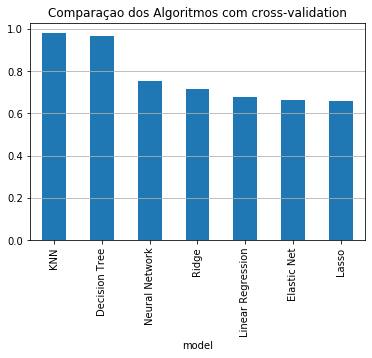

In [85]:
compare_algorithms(models_names_cv, models_results_cv, 'Comparaçao dos Algoritmos com cross-validation')

Nesta fase os algoritmos KNN e Decision Tree destacam-se dos demais.

# Dimensionality reduction - PCA

Para executar a redução de dimensionalidade é necessário fazer primeiro a normalização escalar padrão.

In [180]:
features = electric_motor_temp.drop('pm', 1).values
target = electric_motor_temp['pm'].values
sc = StandardScaler()
features = sc.fit_transform(features)

Precisamos de saber qual o número de componentes que iremos utilizar.

Text(0, 0.5, 'cumulative explained variance')

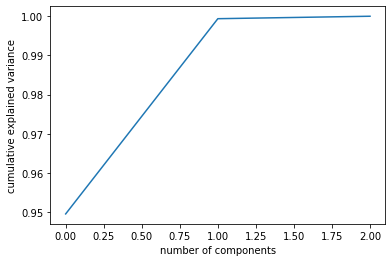

In [181]:
pca_train = PCA().fit(features)
plt.plot(np.cumsum(pca_train.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Função que devolve o número de componentes ideal.

In [182]:
def select_n_components(var_ratio, goal_var: float) -> int:
    total_variance = 0.0
    n_components = 0
    for explained_variance in var_ratio:
        total_variance += explained_variance
        n_components += 1
        if total_variance >= goal_var:
            break

    return n_components

In [183]:
pca_var_ratio = pca_train.explained_variance_ratio_
n_components = select_n_components(pca_var_ratio, 0.99)
print('O número de componentes é ' + str(n_components))
pca = PCA(n_components=n_components)
features = pca.fit_transform(features)
features = pd.DataFrame(data = features)

O número de componentes é 2


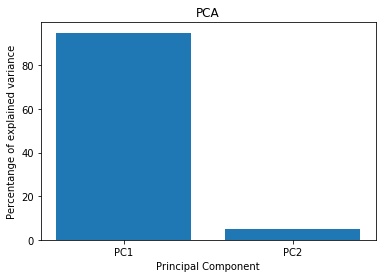

In [184]:
perc = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
fields = ['PC' + str(x) for x in range(1, len(perc) + 1)]
plt.bar(x=range(1, len(perc)+1), height=perc, tick_label=fields)
plt.ylabel('Percentange of explained variance')
plt.xlabel('Principal Component')
plt.title('PCA')
plt.show()

Para uma validação completa, é averiguado os resultados dos algoritmos com cross-validation e PCA.

In [91]:
pca_models_names, pca_models_results = metrics_cv(models, True)

Linear Regression:
	Mean Absolute Error: -0.44681767255433147 (0.0013539724977126074)
	Mean Squared Error: -0.36374981264492756 (0.002307876141219623)
	R-Squared: 0.637081523525808 (0.0021714490103338356)

Lasso:
	Mean Absolute Error: -0.46448954949464794 (0.0011369655270659128)
	Mean Squared Error: -0.376098311197833 (0.0017171096896088805)
	R-Squared: 0.6247618207871443 (0.001365243704356406)

Ridge:
	Mean Absolute Error: -0.4288081250529093 (0.0011048661619596537)
	Mean Squared Error: -0.3252030536416379 (0.001709736827058985)
	R-Squared: 0.675539444578609 (0.0017086842281306242)

Elastic Net:
	Mean Absolute Error: -0.4479515645434898 (0.0010983046425977099)
	Mean Squared Error: -0.35027731279175456 (0.0016575854067635211)
	R-Squared: 0.6505235901872473 (0.0013889648426579034)

Decision Tree:
	Mean Absolute Error: -0.1148143132315667 (0.0013212913305395214)
	Mean Squared Error: -0.11647857112253586 (0.0021052396061820313)
	R-Squared: 0.8837846649885744 (0.002246032762548785)

KNN:
	

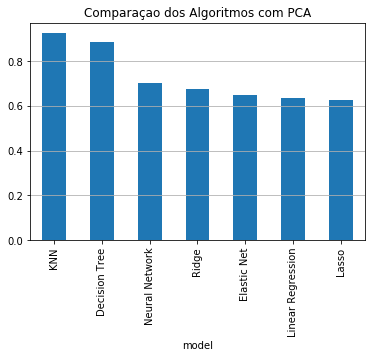

In [92]:
compare_algorithms(pca_models_names, pca_models_results, 'Comparaçao dos Algoritmos com PCA')

Aplicando a redução da dimensionalidade com o PCA, continua-se a ter os algoritmos KNN e Decision Tree como os que apresentam melhores resultados.

# Improve Accuracy

Nesta fase ir-se-á tentar melhorar os resultados dos 2 melhores algoritmos anteriores.

## Algorithm Tuning

Para tentar melhorar os resultados, é feita uma "busca" pelos melhores parâmetros de cada modelo.
Após encontrar os melhores parâmetros para cada modelo, são criados os modelos com esses parâmetros de forma automática.

### K-Nearest Neighbors Regressor

Para o KNN testa-se qual o número de k que apresenta melhores resultados.

In [93]:
def r2_k_knn():
    r2_list = []
    for k in range(15):
        k = k+1
        model = KNeighborsRegressor(n_neighbors = k)
        shufflesplit = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
        cv_r2 = cross_val_score(model, features, target, cv=shufflesplit, scoring='r2')
        r2_list.append(cv_r2.mean())
        print('K = {}, R-Squared: {}'.format(k, cv_r2.mean()))
        
    return r2_list

In [94]:
r2_list = r2_k_knn()

K = 1, R-Squared: 0.9028439338879528
K = 2, R-Squared: 0.9251857823656312
K = 3, R-Squared: 0.9319030477285665
K = 4, R-Squared: 0.9336911595754996
K = 5, R-Squared: 0.9336370416152088
K = 6, R-Squared: 0.9327711199296422
K = 7, R-Squared: 0.9317141229224075
K = 8, R-Squared: 0.9305172375134138
K = 9, R-Squared: 0.9291984958556574
K = 10, R-Squared: 0.9278704631364552
K = 11, R-Squared: 0.9265753197100558
K = 12, R-Squared: 0.9253479489519367
K = 13, R-Squared: 0.9241555597478801
K = 14, R-Squared: 0.9229382924127831
K = 15, R-Squared: 0.9217931761107969


In [95]:
def plot_n_neighbors(r2_list):
    curve = pd.DataFrame(r2_list)
    curve.plot()

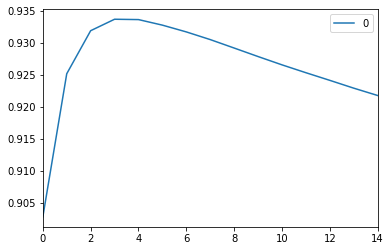

In [96]:
plot_n_neighbors(r2_list)

In [97]:
def best_k():
    n_neighbors = list(range(1,10))
    weights = ['uniform', 'distance']
    algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
    leaf_size = list(range(1,30))
    p = [1, 2, 3, 4, 5]
    random_grid = {'n_neighbors': n_neighbors, 'weights': weights, 'algorithm': algorithm, 'leaf_size': leaf_size, 'p': p}
    rf_random = RandomizedSearchCV(estimator = KNeighborsRegressor(), param_distributions = random_grid, n_iter = 10, cv = shufflesplit, verbose=2, random_state = 42, n_jobs = -1)
    rf_random.fit(features,target)
    print(rf_random.best_params_)
    return rf_random.best_params_

In [98]:
knn_best_params = best_k()

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 84.3min finished


{'weights': 'distance', 'p': 3, 'n_neighbors': 6, 'leaf_size': 12, 'algorithm': 'kd_tree'}


### Decision Tree

Para o Decision Tree testa-se vários parâmetros que estão descritos abaixo para averiguar quais apresentam melhores resultados.

In [99]:
def decision_tree_tuning():
    min_samples_split = [2, 5, 10, 20]
    min_samples_leaf = [1, 2, 4, 8]
    max_features = ['auto', 'sqrt', 'log2']
    max_depth = [2,5,10,20,40,80,100,200,400,800,1600,32000,64000]
    random_grid = {'max_features': max_features, 'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split}
    rf_random = RandomizedSearchCV(estimator = DecisionTreeRegressor(), param_distributions = random_grid, n_iter = 10, cv = shufflesplit, verbose=2, random_state = 42, n_jobs = -1)
    rf_random.fit(features,target)
    print(rf_random.best_params_)
    return rf_random.best_params_

In [100]:
decision_tree_best_params = decision_tree_tuning()

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.4s finished


{'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 800}


Tendo já os melhores parâmetros para cada modelo, é criada uma lista com esses algortimos e esses parâmetros.

In [101]:
tuning_models = []
tuning_models.append(('KNN', KNeighborsRegressor(weights = knn_best_params.get('weights'), p = knn_best_params.get('p'), n_neighbors = knn_best_params.get('n_neighbors'), leaf_size = knn_best_params.get('leaf_size'), algorithm = knn_best_params.get('algorithm'), n_jobs = -1)))
tuning_models.append(('Decision Tree', DecisionTreeRegressor(min_samples_split = decision_tree_best_params.get('min_samples_split'), min_samples_leaf = decision_tree_best_params.get('min_samples_leaf'), max_features = decision_tree_best_params.get('max_features'), max_depth = decision_tree_best_params.get('max_depth'), random_state = 42)))

In [102]:
tuning_models_names, tuning_models_results = metrics_cv(tuning_models, True)

KNN:
	Mean Absolute Error: -0.10355473813729055 (0.0008091272759879217)
	Mean Squared Error: -0.06617392821025622 (0.001066620186086515)
	R-Squared: 0.9339753628739441 (0.001169874213884714)

Decision Tree:
	Mean Absolute Error: -0.13112126915645317 (0.0005878809330202978)
	Mean Squared Error: -0.08991326190818405 (0.0011682843794045819)
	R-Squared: 0.910290796166594 (0.001256336360226838)



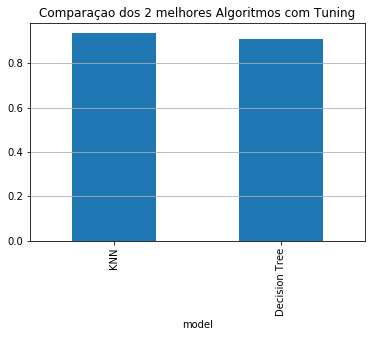

In [103]:
compare_algorithms(tuning_models_names, tuning_models_results, 'Comparaçao dos 2 melhores Algoritmos com Tuning')

Claramente existiu uma melhoria nos resultados, sendo essas melhorias as seguintes:

- KNN: 0.9251857823656312 -> 0.9339753628739441
- Decision Tree: 0.8837846649885744 -> 0.910290796166594

## Ensembles

Para além dos algoritmos anteriores, ir-se-á testar alguns algoritmos e técnicas Ensembles.

Bagging algorithms:

- Random Forest Regressor
- Extra Trees Regressor

Boosting algorithms:

- Adaboost Regressor
- Gradient Boosting Regressor
- XGBoost Regressor

É criada uma lista com esses modelos.

In [104]:
ensembles_models = []
# Bagging algorithms
ensembles_models.append(('Random Forest', RandomForestRegressor(n_estimators = 10, random_state = 42, n_jobs=-1)))
ensembles_models.append(('Extra Trees', ExtraTreesRegressor(n_estimators=10, n_jobs=-1, random_state=42)))
# Boosting algorithms
ensembles_models.append(('AdaBoost', AdaBoostRegressor(n_estimators=10, random_state=42)))
ensembles_models.append(('Gradient Boosting', GradientBoostingRegressor(random_state=42)))
ensembles_models.append(('XGBoost', xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)))

In [105]:
ensembles_models_names, ensembles_models_results = metrics_cv(ensembles_models, True)

Random Forest:
	Mean Absolute Error: -0.11343553887507514 (0.0010204291635051348)
	Mean Squared Error: -0.07470359123702182 (0.0012009328888411479)
	R-Squared: 0.9254653899128537 (0.001293114148726918)

Extra Trees:
	Mean Absolute Error: -0.1079284849945213 (0.000870795000678347)
	Mean Squared Error: -0.07156216460620093 (0.0012090676005581933)
	R-Squared: 0.9285981537035457 (0.0013759525594481646)

AdaBoost:
	Mean Absolute Error: -0.4408764016414521 (0.00889019289295793)
	Mean Squared Error: -0.3119681256846682 (0.010812982809564338)
	R-Squared: 0.6887436752849669 (0.010821681716526928)

Gradient Boosting:
	Mean Absolute Error: -0.3284254259419296 (0.0014129825538776609)
	Mean Squared Error: -0.21466681865276244 (0.0015900643094340489)
	R-Squared: 0.7858243773501474 (0.0014366761106535152)

XGBoost:
	Mean Absolute Error: -0.32824566622226864 (0.001282958476871875)
	Mean Squared Error: -0.21418158114622082 (0.001451859103835941)
	R-Squared: 0.7863072071578107 (0.001483596236859977)



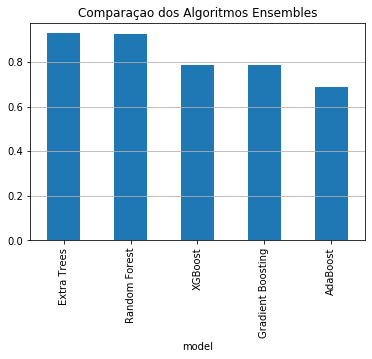

In [106]:
compare_algorithms(ensembles_models_names, ensembles_models_results, 'Comparaçao dos Algoritmos Ensembles')

Claramente que os Bagging algorithms - Extra Trees e Random Forest foram os que apresentaram melhores resultados.

### Ensembles Tuning

Para tentar melhorar os resultados dos algoritmos Ensembles, é feita uma "busca" pelos melhores parâmetros de cada algortimo.

#### Random Forest Regressor

In [107]:
def random_forest_tuning():
    n_estimators = [200, 300, 500]
    min_samples_split = [2, 5, 10, 20]
    min_samples_leaf = [1, 2, 4, 8]
    max_features = ['auto', 'sqrt', 'log2']
    max_depth = [2,5,10,20,40,80,100,200,400,800,1600,32000,64000]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}
    rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = random_grid, n_iter = 10, cv = shufflesplit, verbose=2, random_state = 42, n_jobs = -1)
    rf_random.fit(features,target)
    print(rf_random.best_params_)
    return rf_random.best_params_

In [108]:
random_forest_best_params = random_forest_tuning()

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 75.1min finished


{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 32000, 'bootstrap': True}


#### Extra Trees Regressor

In [109]:
def extra_trees_tuning():
    n_estimators = [200, 300, 500]
    min_samples_split = [2, 5, 10, 20]
    min_samples_leaf = [1, 2, 4, 8]
    max_features = ['auto', 'sqrt', 'log2']
    max_depth = [2,5,10,20,40,80,100,200,400,800,1600,32000,64000]
    random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split}
    rf_random = RandomizedSearchCV(estimator = ExtraTreesRegressor(), param_distributions = random_grid, n_iter = 10, cv = shufflesplit, verbose=2, random_state = 42, n_jobs = -1)
    rf_random.fit(features,target)
    print(rf_random.best_params_)
    return rf_random.best_params_

In [110]:
extra_trees_best_params = extra_trees_tuning()

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 20.1min finished


{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 1600}


Tendo já os melhores parâmetros para cada modelo, é criada uma lista com esses algortimos e esses parâmetros.

In [111]:
tuning_ensembles_models = []
tuning_ensembles_models.append(('Random Forest', RandomForestRegressor(n_estimators = random_forest_best_params.get('n_estimators'), min_samples_split = random_forest_best_params.get('min_samples_split'), min_samples_leaf = random_forest_best_params.get('min_samples_leaf'), max_features = random_forest_best_params.get('max_features'), max_depth = random_forest_best_params.get('max_depth'), bootstrap = random_forest_best_params.get('bootstrap'), random_state = 42, n_jobs=-1)))
tuning_ensembles_models.append(('Extra Trees', ExtraTreesRegressor(n_estimators = extra_trees_best_params.get('n_estimators'), min_samples_split = extra_trees_best_params.get('min_samples_split'), min_samples_leaf = extra_trees_best_params.get('min_samples_leaf'), max_features = extra_trees_best_params.get('max_features'), max_depth = extra_trees_best_params.get('max_depth'), n_jobs = -1, random_state = 42)))

In [112]:
tuning_ensembles_models_names, tuning_ensembles_models_results = metrics_cv(tuning_ensembles_models, True)

Random Forest:
	Mean Absolute Error: -0.1320230447645593 (0.0006219213862959167)
	Mean Squared Error: -0.07170106314731924 (0.0007550800238497156)
	R-Squared: 0.9284612376463681 (0.0008772239989877996)

Extra Trees:
	Mean Absolute Error: -0.12390701559343271 (0.0006283717093099585)
	Mean Squared Error: -0.06554856690073893 (0.000759257374918995)
	R-Squared: 0.9345996616082312 (0.0008729691334936874)



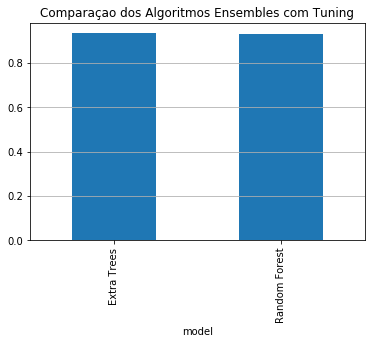

In [113]:
compare_algorithms(tuning_ensembles_models_names, tuning_ensembles_models_results, 'Comparaçao dos Algoritmos Ensembles com Tuning')

Existiu uma melhoria nos resultados, sendo essas melhorias as seguintes:

- Random Forest: 0.9254653899128537 -> 0.9284612376463681 
- Extra Trees: 0.9285981537035457 -> 0.9345996616082312  

### Voting Regressor

É utilizada a técnica de Ensemble - Voting Regressor com os 2 melhores modelos Ensembles com os parâmetros que apresentam os melhores resultados.

In [114]:
def voting_regressor(models):
    ensemble = VotingRegressor(models)
    cv_mae = cross_val_score(ensemble, features, target, cv=shufflesplit, scoring='neg_mean_absolute_error')
    cv_mse = cross_val_score(ensemble, features, target, cv=shufflesplit, scoring='neg_mean_squared_error')
    cv_r2 = cross_val_score(ensemble, features, target, cv=shufflesplit, scoring='r2')
    name = ['Voting Regressor']
    result = [cv_r2.mean()]
        
    print('Voting Regressor with Random Forest and Extra Trees:')
    print('\tMean Absolute Error: {} ({})'.format(cv_mae.mean(), cv_mae.std()))
    print('\tMean Squared Error: {} ({})'.format(cv_mse.mean(), cv_mse.std()))
    print('\tR-Squared: {} ({})\n'.format(cv_r2.mean(), cv_r2.std()))
    
    return name, result

In [115]:
voting_regressor_models_name, voting_regressor_models_result = voting_regressor(tuning_ensembles_models)

Voting Regressor with Random Forest and Extra Trees:
	Mean Absolute Error: -0.12735963283448912 (0.0006159702780833579)
	Mean Squared Error: -0.06783713926333752 (0.0007471183165797509)
	R-Squared: 0.9323163583419414 (0.0008627094344358636)



A técnica - Voting Regressor com os 2 melhores modelos Ensembles com os parâmetros que apresentam os melhores resultados, apresentou melhores resultados que o Random Forest mas apresentou piores do que o Extra Trees.

### Bagging Regressor

É utilizada a técnica de Ensemble - Bagging Regressor com os 2 melhores modelos iniciais com os parâmetros que apresentam os melhores resultados.

In [116]:
def bagging_regressor(models):
    results = []
    names = []
    for name, model in models:
        model = BaggingRegressor(model)
        shufflesplit = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
        cv_mae = cross_val_score(model, features, target, cv=shufflesplit, scoring='neg_mean_absolute_error')
        cv_mse = cross_val_score(model, features, target, cv=shufflesplit, scoring='neg_mean_squared_error')
        cv_r2 = cross_val_score(model, features, target, cv=shufflesplit, scoring='r2')
        results.append(cv_r2.mean())
        names.append('Bagging ' + str(name))
        
        print('Bagging ' + str(name) + ':')
        print('\tMean Absolute Error: {} ({})'.format(cv_mae.mean(), cv_mae.std()))
        print('\tMean Squared Error: {} ({})'.format(cv_mse.mean(), cv_mse.std()))
        print('\tR-Squared: {} ({})\n'.format(cv_r2.mean(), cv_r2.std()))
    
    return names, results

In [117]:
bagging_models_names, bagging_models_results = bagging_regressor(tuning_models)

Bagging KNN:
	Mean Absolute Error: -0.10618686695910581 (0.0008234454406070116)
	Mean Squared Error: -0.0659527820396925 (0.000905526850573007)
	R-Squared: 0.934259175790204 (0.0010477895408215227)

Bagging Decision Tree:
	Mean Absolute Error: -0.13556910390599833 (0.0006937297584064141)
	Mean Squared Error: -0.07770715945271298 (0.0009531955777158275)
	R-Squared: 0.9225060818924635 (0.0008859707868968216)



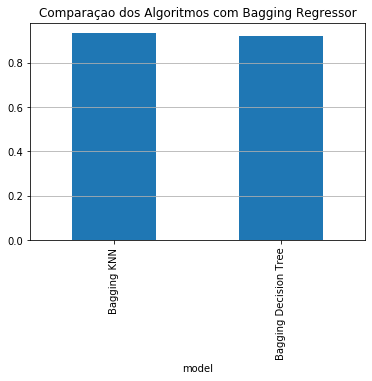

In [118]:
compare_algorithms(bagging_models_names, bagging_models_results, 'Comparaçao dos Algoritmos com Bagging Regressor')

Com a utilização desta técnica - Bagging meta-estimator permitiu melhorar os resultados.

- KNN: 0.9339753628739441 -> Bagging with KNN: 0.934259175790204
- Decision Tree: 0.910290796166594 -> Bagging with Decision Tree: 0.9225060818924635

### Bagging Regressor Tuning

Mais uma vez, é utilizado a mesma técnica para tentar encontrar os melhores parâmetros que resultam nos melhores resultados possíveis, mas desta vez para os algoritmos 2 melhores algoritmos com Bagging Regressor.

#### Bagging KNN Regressor

In [119]:
def bagging_regressor_knn_tuning():
    model = KNeighborsRegressor(weights = knn_best_params.get('weights'), p = knn_best_params.get('p'), n_neighbors = knn_best_params.get('n_neighbors'), leaf_size = knn_best_params.get('leaf_size'), algorithm = knn_best_params.get('algorithm'), n_jobs = -1)
    n_estimators = [200, 300, 500]
    max_samples = [0.25, 0.5, 0.75, 1.0]
    max_features = [0.25, 0.5, 0.75, 1.0]
    bootstrap = [True, False]
    bootstrap_features = [True, False]
    warm_start = [True, False]
    random_grid = {'n_estimators': n_estimators, 'max_samples': max_samples, 'max_features': max_features, 'bootstrap': bootstrap, 'bootstrap_features': bootstrap_features, 'warm_start': warm_start}
    rf_random = RandomizedSearchCV(estimator = BaggingRegressor(base_estimator = model), param_distributions = random_grid, n_iter = 10, cv = shufflesplit, verbose=2, random_state = 42, n_jobs = -1)
    rf_random.fit(features,target)
    print(rf_random.best_params_)
    
    
    return rf_random.best_params_

In [120]:
bagging_knn_best_params = bagging_regressor_knn_tuning()

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 27.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 107.6min finished


{'warm_start': True, 'n_estimators': 200, 'max_samples': 0.75, 'max_features': 1.0, 'bootstrap_features': False, 'bootstrap': False}


#### Bagging Decision Tree Regressor

In [121]:
def bagging_regressor_decision_tree_tuning():
    model = DecisionTreeRegressor(min_samples_split = decision_tree_best_params.get('min_samples_split'), min_samples_leaf = decision_tree_best_params.get('min_samples_leaf'), max_features = decision_tree_best_params.get('max_features'), max_depth = decision_tree_best_params.get('max_depth'), random_state = 42)
    n_estimators = [200, 300, 500]
    max_samples = [0.25, 0.5, 0.75, 1.0]
    max_features = [0.25, 0.5, 0.75, 1.0]
    bootstrap = [True, False]
    bootstrap_features = [True, False]
    warm_start = [True, False]
    random_grid = {'n_estimators': n_estimators, 'max_samples': max_samples, 'max_features': max_features, 'bootstrap': bootstrap, 'bootstrap_features': bootstrap_features, 'warm_start': warm_start}
    rf_random = RandomizedSearchCV(estimator = BaggingRegressor(base_estimator = model), param_distributions = random_grid, n_iter = 10, cv = shufflesplit, verbose=2, random_state = 42, n_jobs = -1)
    rf_random.fit(features,target)
    print(rf_random.best_params_)
    return rf_random.best_params_

In [122]:
bagging_decision_tree_best_params = bagging_regressor_decision_tree_tuning()

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 75.8min finished


{'warm_start': False, 'n_estimators': 300, 'max_samples': 0.75, 'max_features': 1.0, 'bootstrap_features': False, 'bootstrap': False}


É criada uma lista com os algoritmos e os melhores parâmetros.

In [123]:
knn = KNeighborsRegressor(weights = knn_best_params.get('weights'), p = knn_best_params.get('p'), n_neighbors = knn_best_params.get('n_neighbors'), leaf_size = knn_best_params.get('leaf_size'), algorithm = knn_best_params.get('algorithm'), n_jobs = -1)
decision_tree = DecisionTreeRegressor(min_samples_split = decision_tree_best_params.get('min_samples_split'), min_samples_leaf = decision_tree_best_params.get('min_samples_leaf'), max_features = decision_tree_best_params.get('max_features'), max_depth = decision_tree_best_params.get('max_depth'), random_state = 42)
tuning_bagging_regressor_models = []
tuning_bagging_regressor_models.append(('Bagging KNN', BaggingRegressor(base_estimator = knn, n_estimators = bagging_knn_best_params.get('n_estimators'), max_samples = bagging_knn_best_params.get('max_samples'), max_features = bagging_knn_best_params.get('max_features'), bootstrap = bagging_knn_best_params.get('bootstrap'), bootstrap_features = bagging_knn_best_params.get('bootstrap_features'), warm_start = bagging_knn_best_params.get('warm_start'), random_state = 42)))
tuning_bagging_regressor_models.append(('Bagging Decision Tree', BaggingRegressor(base_estimator = decision_tree, n_estimators = bagging_decision_tree_best_params.get('n_estimators'), max_samples = bagging_decision_tree_best_params.get('max_samples'), max_features = bagging_decision_tree_best_params.get('max_features'), bootstrap = bagging_decision_tree_best_params.get('bootstrap'), bootstrap_features = bagging_decision_tree_best_params.get('bootstrap_features'), warm_start = bagging_decision_tree_best_params.get('warm_start'), random_state = 42)))

In [124]:
tuning_bagging_models_names, tuning_bagging_models_results = metrics_cv(tuning_bagging_regressor_models, True)

Bagging KNN:
	Mean Absolute Error: -0.10845818034749888 (0.0007340901906822329)
	Mean Squared Error: -0.06592836240138564 (0.0009552752362072042)
	R-Squared: 0.9342204342605417 (0.001065827060407293)

Bagging Decision Tree:
	Mean Absolute Error: -0.12981346808171498 (0.0006820470568908298)
	Mean Squared Error: -0.07510031595965014 (0.0008803648734336319)
	R-Squared: 0.9250700833641424 (0.0009649183257396028)



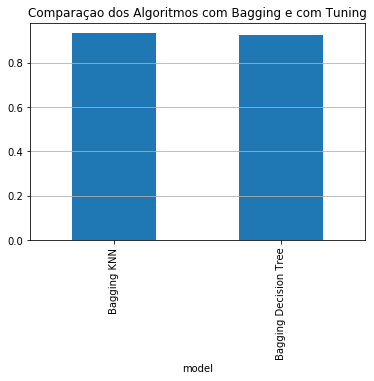

In [125]:
compare_algorithms(tuning_bagging_models_names, tuning_bagging_models_results, 'Comparaçao dos Algoritmos com Bagging e com Tuning')

Utilizando os melhores parâmetros, os resultados pouco se alteraram:

- Bagging with KNN: 0.934259175790204 -> 0.9342204342605417
- Bagging with Decision Tree: 0.9225060818924635 -> 0.9250700833641424

É criada uma lista com os melhores algortimos Ensembles com os parâmetros que apresentam melhores resultados.

- Bagging algorithms
- Voting Regressor com os Bagging algorithms
- Bagging KNN
- Bagging Decision Tree

In [126]:
best_models_results = tuning_ensembles_models_results + voting_regressor_models_result + tuning_bagging_models_results
best_models_names = tuning_ensembles_models_names + voting_regressor_models_name + tuning_bagging_models_names

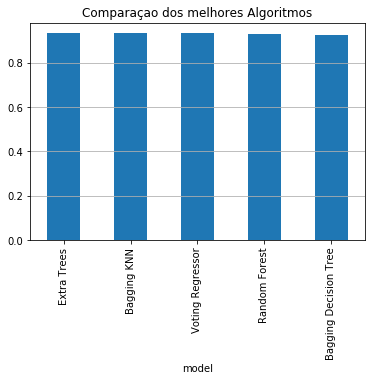

In [127]:
compare_algorithms(best_models_names, best_models_results, 'Comparaçao dos melhores Algoritmos')

Todos os modelos apresentam resultados muito bons, mas escolhendo apenas os 2 melhores, são escolhidos o Extra Trees e o Bagging KNN.

# Finalize Model

Nesta fase final é criado o modelo final com o Voting Regressor, utilizando o Extra Trees e o Bagging KNN.

É criada uma lista com o Voting Regressor, utilizando o Extra Trees e o Bagging KNN.

In [426]:
best_models = []
best_models.append(('Extra Trees', ExtraTreesRegressor(n_estimators = extra_trees_best_params.get('n_estimators'), min_samples_split = extra_trees_best_params.get('min_samples_split'), min_samples_leaf = extra_trees_best_params.get('min_samples_leaf'), max_features = extra_trees_best_params.get('max_features'), max_depth = extra_trees_best_params.get('max_depth'), n_jobs = -1, random_state = 42)))
best_models.append(('Bagging KNN', BaggingRegressor(base_estimator = knn, n_estimators = bagging_knn_best_params.get('n_estimators'), max_samples = bagging_knn_best_params.get('max_samples'), max_features = bagging_knn_best_params.get('max_features'), bootstrap = bagging_knn_best_params.get('bootstrap'), bootstrap_features = bagging_knn_best_params.get('bootstrap_features'), warm_start = bagging_knn_best_params.get('warm_start'), random_state = 42, n_jobs=-1)))
final_model = VotingRegressor(best_models)

Existe a necessidade de nomear as features e o target outra vez e criar a divisão de treino e de teste, para não se utilizar o PCA, porque o objetivo é guardar o treino das 3 features e não apenas 2, isto porque o PCA utiliza apenas 2 componentes.

In [427]:
features = electric_motor_temp.drop('pm', 1)
target = electric_motor_temp['pm']

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

## Predictions on validation dataset

Validação final ao modelo com as métricas e a validação de 20 registos aleatórios.

In [430]:
def final_predictions(model):
    model.fit(x_train, y_train)
    predict = model.predict(x_test)
        
    print('Test Final Model:')
    print('\t\tMean Absolute Error: {}'.format(mean_absolute_error(y_test, predict)))
    print('\t\tMean Squared Error: {}'.format(mean_squared_error(y_test, predict)))
    print('\t\tR-Squared: {}\n'.format(r2_score(y_test, predict)))
    
    print('Test 20 temperatures:\n')
    for i in range(20):
        i = random.choice(x_test.index.tolist())
        prediction = model.predict(x_test.loc[[i],:])
        prediction_rounded = round(prediction[0], 3)
        real_value_rounded = round(y_test[i], 3)
        print('\tReal Value: ' + str(real_value_rounded) + ', Predicted Value: ' + str(prediction_rounded) + '\n')

    return predict

In [431]:
predict = final_predictions(final_model)

Test Final Model:
		Mean Absolute Error: 0.05223550124002975
		Mean Squared Error: 0.019969920281616826
		R-Squared: 0.9800793563301545

Test 20 temperatures:

	Real Value: -0.331, Predicted Value: -0.336

	Real Value: 0.026, Predicted Value: 0.163

	Real Value: 2.262, Predicted Value: 2.256

	Real Value: -1.218, Predicted Value: -1.217

	Real Value: -0.059, Predicted Value: -0.074

	Real Value: 1.304, Predicted Value: 1.3

	Real Value: -0.7, Predicted Value: -0.726

	Real Value: -1.616, Predicted Value: -1.618

	Real Value: 1.329, Predicted Value: 1.33

	Real Value: 0.39, Predicted Value: 0.355

	Real Value: 0.585, Predicted Value: 0.591

	Real Value: -0.584, Predicted Value: -0.592

	Real Value: 0.033, Predicted Value: 0.046

	Real Value: 1.333, Predicted Value: 1.331

	Real Value: 1.725, Predicted Value: 1.696

	Real Value: 0.806, Predicted Value: 0.801

	Real Value: 0.325, Predicted Value: 0.327

	Real Value: 0.876, Predicted Value: 0.634

	Real Value: 1.715, Predicted Value: 1.719

In [409]:
def plot_predictions(predict):
    sns.kdeplot(predict, label = 'Predictions')
    sns.kdeplot(y_test, label = 'Real Values')
    plt.xlabel('PM')
    plt.ylabel('Density')
    plt.title('Test Predictions')

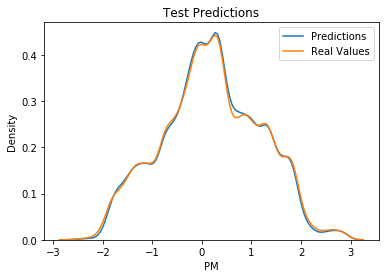

In [410]:
plot_predictions(predict)

Visualizando os resultados e o gráfico, de facto este modelo tem uma margem de erro pequena e as predições ajustam-se bem aos valores de teste.

## Create standalone model on entire training dataset and Save model for later use

Por fim é guardado o modelo treinado para ser utilizado quando se quiser. É treinado com todo o conjunto de dados.

In [411]:
def save_model(model, file):
    model.fit(features, target)
    pickle.dump(model, open(file, 'wb'))
    print('Model saved!')

In [412]:
save_model(final_model, 'final_model.pkl')

Model saved!


# Load and use the final model

Agora é possível carregar o modelo e prever com outros dados, neste caso importados por um novo ficheiro.

In [416]:
df_test = pd.read_csv('electric_car_temp_test.csv')
df_test = df_test.loc[:,['stator_yoke', 'stator_winding', 'stator_tooth', 'pm']]
features = df_test.drop('pm', 1)
target = df_test['pm']

In [422]:
def predict(file):
    model = pickle.load(open(file, 'rb'))
    pred = model.predict(features)
    print('Final model:\n')
    for i in range(len(target)):
        prediction = model.predict(features.loc[[i],:])
        prediction_rounded = round(prediction[0], 3)
        real_value_rounded = round(target[i], 3)
        print('\tReal Value: ' + str(real_value_rounded) + ', Predicted Value: ' + str(prediction_rounded) + '\n')

In [423]:
predict('final_model.pkl')

Final model:

	Real Value: -2.522, Predicted Value: -2.522

	Real Value: -2.142, Predicted Value: -2.028

	Real Value: 0.43, Predicted Value: 0.291

	Real Value: 0.205, Predicted Value: -0.271

	Real Value: 1.387, Predicted Value: 1.323

	Real Value: -2.197, Predicted Value: -1.695

	Real Value: -0.677, Predicted Value: 1.186

	Real Value: 1.478, Predicted Value: 1.285

	Real Value: 1.707, Predicted Value: 1.7

	Real Value: 0.429, Predicted Value: 0.699

